# Initializing project

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

import time

#for google access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
project_path = "/content/drive/My Drive/CSCI_534 Project/Project/AMC Data"
# project_path = './'

amc_stock = pd.read_csv(project_path+'/AMC Stock Data.csv') #181 of sample
amc_vader = pd.read_csv(project_path+'/amc_english_vader.csv',index_col=0) #108817 of samples

In [6]:
amc_vader.shape #108817

(93342, 7)

In [7]:
amc_vader['Datetime'].unique

<bound method Series.unique of 0        2020-12-06 23:34:01+00:00
1        2020-12-06 22:51:31+00:00
2        2020-12-06 22:47:58+00:00
3        2020-12-06 22:46:19+00:00
4        2020-12-06 22:20:15+00:00
                   ...            
93337    2021-02-07 00:06:34+00:00
93338    2021-02-07 00:05:47+00:00
93339    2021-02-07 00:04:17+00:00
93340    2021-02-07 00:00:53+00:00
93341    2021-02-07 00:00:10+00:00
Name: Datetime, Length: 93342, dtype: object>

# Preparing data
In this part, we will combine and prepare the data is neccessary for the model to learn such as date, stock price and vader scores.

Preparing data for AMC

In [8]:
#In this part we are preparing data for processing (taking datetime and scores from vader data)
amc_vader_date = amc_vader['Datetime'].to_numpy()
amc_vader_scores = amc_vader['scores'].to_numpy()

NEG = 1
NEU = 3
POS = 5
COM = -1 #remove '}'

In [9]:
#Cleaning amc data
amc_vader_neg =[]
amc_vader_neu =[]
amc_vader_pos =[]
amc_vader_com =[] #don't know if needed
for i in range(len(amc_vader_date)):
  amc_vader_date[i] = amc_vader_date[i].split()[0]    #cleaning the data only the date
  #change date fromat
  #mm/dd/yyy
  amc_vader_date[i]=time.strptime(amc_vader_date[i],'%Y-%m-%d') 
  amc_vader_date[i]=time.strftime('%m/%d/%Y',amc_vader_date[i])

  res = amc_vader_scores[i].replace(',','').split()
  amc_vader_neg.append(float(res[NEG]))
  amc_vader_neu.append(float(res[NEU]))
  amc_vader_pos.append(float(res[POS]))
  amc_vader_com.append(float(res[COM].replace("}","")))


In [10]:
#put amc vader data in df
amc_vader_df = pd.DataFrame({
    'Date':amc_vader_date,
    'neg':amc_vader_neg,
    'neu':amc_vader_neu,
    'pos':amc_vader_pos,
    'com':amc_vader_com
})
#combine data on the same date(caculate the descriptive statistics of "neg","neu","pos","com")
#mean
amc_vader_df_mean = amc_vader_df.groupby(['Date']).agg({'neg':np.mean,'neu':np.mean,'pos':np.mean,'com':np.mean}).reset_index()
#median
amc_vader_df_median = amc_vader_df.groupby(['Date']).agg({'neg':np.median,'neu':np.median,'pos':np.median,'com':np.median}).reset_index()
#std
amc_vader_df_std = amc_vader_df.groupby(['Date']).agg({'neg':np.std,'neu':np.std,'pos':np.std,'com':np.std}).reset_index()
#max
amc_vader_df_max = amc_vader_df.groupby(['Date']).agg({'neg':np.max,'neu':np.max,'pos':np.max,'com':np.max}).reset_index()
#min
amc_vader_df_min = amc_vader_df.groupby(['Date']).agg({'neg':np.min,'neu':np.min,'pos':np.min,'com':np.min}).reset_index()
#skewness
amc_vader_df_skewness = amc_vader_df.groupby(['Date']).agg({'neg':stats.skew,'neu':stats.skew,'pos':stats.skew,'com':stats.skew}).reset_index()
#kurtosis
amc_vader_df_kurtosis = amc_vader_df.groupby(['Date']).agg({'neg':stats.kurtosis,'neu':stats.kurtosis,'pos':stats.kurtosis,'com':stats.kurtosis}).reset_index()
#Jarque-Bera
#To test if the data have normal distribution base on skewness and kurotsis


In [11]:
#clean the stock date(taking datetime and close from stock data)
amc_stock_date = amc_stock['Date'].to_numpy()
amc_stock_close = amc_stock['Close'].to_numpy()

In [12]:
#get stock date and change format
for i in range(len(amc_stock_date)):
  amc_stock_date[i] = amc_stock_date[i].split()[0]
  amc_stock_date[i]=time.strptime(amc_stock_date[i],'%m/%d/%Y')
  amc_stock_date[i]=time.strftime('%m/%d/%Y',amc_stock_date[i])

In [13]:
#put amc stock data in df
amc_stock_df = pd.DataFrame({
    'Date':amc_stock_date,
    'close':amc_stock_close
})

#normalizing the stock value
amc_stock_df['close'] = (amc_stock_df['close'] - amc_stock_df['close'].min()) / (amc_stock_df['close'].max() - amc_stock_df['close'].min())
amc_stock_df

,Date,close
0,07/01/2020,0.144531
1,07/02/2020,0.142299
2,07/06/2020,0.128348
3,07/07/2020,0.119978
4,07/08/2020,0.136719
...,...,...
176,03/15/2021,0.672991
177,03/16/2021,0.616071
178,03/17/2021,0.646205
179,03/18/2021,0.670759


In [14]:
#merge vader mean data and stock data
amc_merge_df_mean = pd.merge(amc_vader_df_mean,amc_stock_df,on='Date',how="left")
amc_merge_df_mean = amc_merge_df_mean.dropna().reset_index(drop=True)
amc_merge_df_mean.shape #Only 20 days worth of data

#median
amc_merge_df_median = pd.merge(amc_vader_df_median,amc_stock_df,on='Date',how="left")
amc_merge_df_median = amc_merge_df_median.dropna().reset_index(drop=True)

#std
amc_merge_df_std = pd.merge(amc_vader_df_std,amc_stock_df,on='Date',how="left")
amc_merge_df_std = amc_merge_df_std.dropna().reset_index(drop=True)

#max
amc_merge_df_max = pd.merge(amc_vader_df_max,amc_stock_df,on='Date',how="left")
amc_merge_df_max = amc_merge_df_max.dropna().reset_index(drop=True)

#min
amc_merge_df_min = pd.merge(amc_vader_df_min,amc_stock_df,on='Date',how="left")
amc_merge_df_min = amc_merge_df_min.dropna().reset_index(drop=True)


In [15]:
amc_merge_df_mean[['neg','neu','pos','com']][:-10].shape[0]

41

# Training the linear model

Training the linear model for AMC

In [16]:
#Creating a model based on the amc data
#amc_merge_df[['neg','neu','pos','com']] is the data or x or feature
#amc_merge_df[['close']] is the label
#mean
reg_amc_mean = LinearRegression().fit(amc_merge_df_mean[['neg','neu','pos','com']][:-10], amc_merge_df_mean[['close']][:-10])
#median
reg_amc_median = LinearRegression().fit(amc_merge_df_median[['neg','neu','pos','com']][:-10], amc_merge_df_median[['close']][:-10])
#std
reg_amc_std = LinearRegression().fit(amc_merge_df_std[['neg','neu','pos','com']][:-10], amc_merge_df_std[['close']][:-10])
#max
reg_amc_max = LinearRegression().fit(amc_merge_df_max[['neg','neu','pos','com']][:-10], amc_merge_df_max[['close']][:-10])
#min
reg_amc_min = LinearRegression().fit(amc_merge_df_min[['neg','neu','pos','com']][:-10], amc_merge_df_min[['close']][:-10])

# Plot the data and model of for each base line

Predict AMC model with all feature

In [17]:
#each model is predicting the label using the data that we have
#pred_amc is a numpy array consisting the values of prediction of the amc data that we use for the training
#mean 
pred_amc_mean = reg_amc_mean.predict(amc_merge_df_mean[['neg','neu','pos','com']][-10:])
#median
pred_amc_median = reg_amc_median.predict(amc_merge_df_median[['neg','neu','pos','com']][-10:])
#std
pred_amc_std = reg_amc_std.predict(amc_merge_df_std[['neg','neu','pos','com']][-10:])
#max
pred_amc_max = reg_amc_max.predict(amc_merge_df_max[['neg','neu','pos','com']][-10:])
#min
pred_amc_min = reg_amc_min.predict(amc_merge_df_min[['neg','neu','pos','com']][-10:])

#To plot the training model
#mean 
train_amc_mean = reg_amc_mean.predict(amc_merge_df_mean[['neg','neu','pos','com']][:-10])
#median
train_amc_median = reg_amc_median.predict(amc_merge_df_median[['neg','neu','pos','com']][:-10])
#std
train_amc_std = reg_amc_std.predict(amc_merge_df_std[['neg','neu','pos','com']][:-10])
#max
train_amc_max = reg_amc_max.predict(amc_merge_df_max[['neg','neu','pos','com']][:-10])
#min
train_amc_min = reg_amc_min.predict(amc_merge_df_min[['neg','neu','pos','com']][:-10])


#In this part, I am combining the data  of each company with the prediction
#mean
amc_merge_pred_mean = pd.concat([amc_merge_df_mean[:-10], pd.DataFrame(train_amc_mean,columns=['pred'])], axis=1)
#median
amc_merge_pred_median = pd.concat([amc_merge_df_median[:-10], pd.DataFrame(train_amc_median,columns=['pred'])], axis=1)
#std
amc_merge_pred_std = pd.concat([amc_merge_df_std[:-10], pd.DataFrame(train_amc_std,columns=['pred'])], axis=1)
#max
amc_merge_pred_max = pd.concat([amc_merge_df_max[:-10], pd.DataFrame(train_amc_max,columns=['pred'])], axis=1)
#min
amc_merge_pred_min = pd.concat([amc_merge_df_min[:-10], pd.DataFrame(train_amc_min,columns=['pred'])], axis=1)

Display the perfomance of the model


In [18]:
from sklearn.metrics import mean_squared_error

#This is the score of the prediction/ performance of the model
#mean
amc_score_mean = mean_squared_error(amc_merge_df_mean[['close']][-10:], pred_amc_mean)
#median
amc_score_median = mean_squared_error(amc_merge_df_median[['close']][-10:], pred_amc_median)
#std
amc_score_std = mean_squared_error(amc_merge_df_std[['close']][-10:], pred_amc_std)
#max
amc_score_max = mean_squared_error(amc_merge_df_max[['close']][-10:], pred_amc_max)
#min
amc_score_min = mean_squared_error(amc_merge_df_min[['close']][-10:], pred_amc_min)
[amc_score_mean,amc_score_median,amc_score_std,amc_score_max,amc_score_min]

[0.015489641212793493,
 0.016334624002811444,
 0.005889076678888579,
 0.00662740139118413,
 0.012992122546185933]

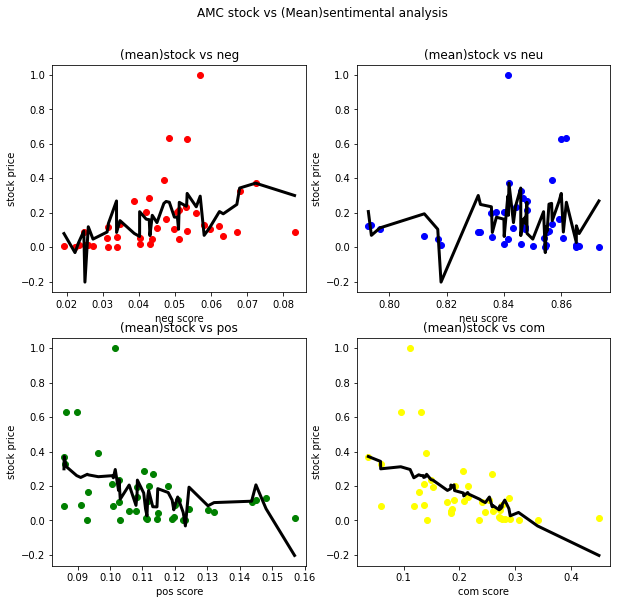

In [19]:
#plot amc
#In this part, it is plotting the data with the stock + the model itself
#Mean sentimental analysis
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('AMC stock vs (Mean)sentimental analysis')
fig.set_size_inches(10,8)

amc_sort_neg_mean = amc_merge_pred_mean.sort_values(by=['neg'])
axs[0,0].scatter(amc_sort_neg_mean[['neg']],amc_sort_neg_mean[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(amc_sort_neg_mean[['neg']], amc_sort_neg_mean[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('(mean)stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

amc_sort_neu_mean = amc_merge_pred_mean.sort_values(by=['neu'])
axs[0,1].scatter(amc_sort_neu_mean[['neu']],amc_sort_neu_mean[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(amc_sort_neu_mean[['neu']], amc_sort_neu_mean[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('(mean)stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

amc_sort_pos_mean = amc_merge_pred_mean.sort_values(by=['pos'])
axs[1,0].scatter(amc_sort_pos_mean[['pos']],amc_sort_pos_mean[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(amc_sort_pos_mean[['pos']], amc_sort_pos_mean[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('(mean)stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

amc_sort_com_mean = amc_merge_pred_mean.sort_values(by=['com'])
axs[1,1].scatter(amc_sort_com_mean[['com']],amc_sort_com_mean[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(amc_sort_com_mean[['com']], amc_sort_com_mean[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('(mean)stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

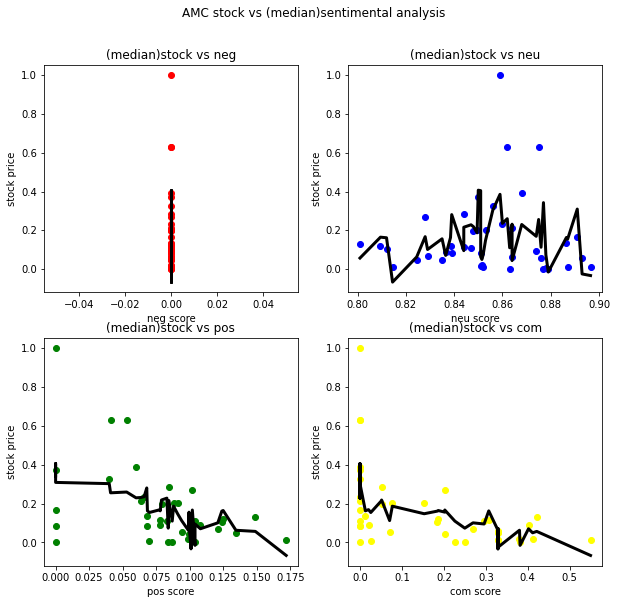

In [20]:
#Median sentimental analysis
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('AMC stock vs (median)sentimental analysis')
fig.set_size_inches(10,8)

amc_sort_neg_median = amc_merge_pred_median.sort_values(by=['neg'])
axs[0,0].scatter(amc_sort_neg_median[['neg']],amc_sort_neg_median[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(amc_sort_neg_median[['neg']], amc_sort_neg_median[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('(median)stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

amc_sort_neu_median = amc_merge_pred_median.sort_values(by=['neu'])
axs[0,1].scatter(amc_sort_neu_median[['neu']],amc_sort_neu_median[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(amc_sort_neu_median[['neu']], amc_sort_neu_median[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('(median)stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

amc_sort_pos_median = amc_merge_pred_median.sort_values(by=['pos'])
axs[1,0].scatter(amc_sort_pos_median[['pos']],amc_sort_pos_median[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(amc_sort_pos_median[['pos']], amc_sort_pos_median[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('(median)stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

amc_sort_com_median = amc_merge_pred_median.sort_values(by=['com'])
axs[1,1].scatter(amc_sort_com_median[['com']],amc_sort_com_median[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(amc_sort_com_median[['com']], amc_sort_com_median[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('(median)stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

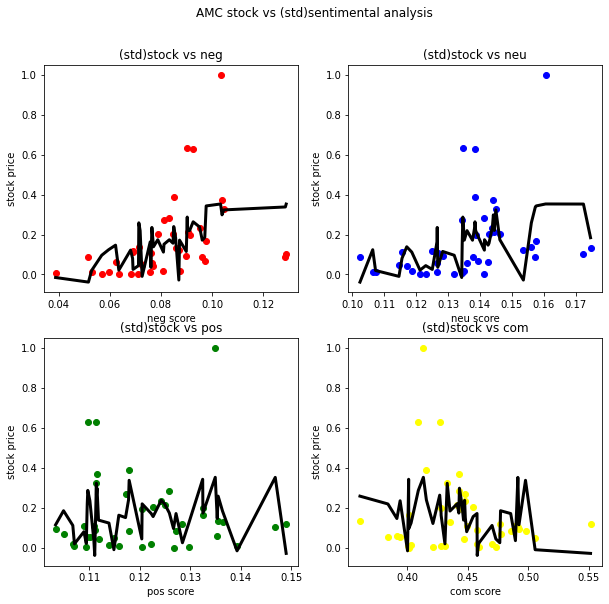

In [21]:
#std sentimental analysis
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('AMC stock vs (std)sentimental analysis')
fig.set_size_inches(10,8)

amc_sort_neg_std = amc_merge_pred_std.sort_values(by=['neg'])
axs[0,0].scatter(amc_sort_neg_std[['neg']],amc_sort_neg_std[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(amc_sort_neg_std[['neg']], amc_sort_neg_std[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('(std)stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

amc_sort_neu_std = amc_merge_pred_std.sort_values(by=['neu'])
axs[0,1].scatter(amc_sort_neu_std[['neu']],amc_sort_neu_std[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(amc_sort_neu_std[['neu']], amc_sort_neu_std[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('(std)stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

amc_sort_pos_std = amc_merge_pred_std.sort_values(by=['pos'])
axs[1,0].scatter(amc_sort_pos_std[['pos']],amc_sort_pos_std[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(amc_sort_pos_std[['pos']], amc_sort_pos_std[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('(std)stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

amc_sort_com_std = amc_merge_pred_std.sort_values(by=['com'])
axs[1,1].scatter(amc_sort_com_std[['com']],amc_sort_com_std[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(amc_sort_com_std[['com']], amc_sort_com_std[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('(std)stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

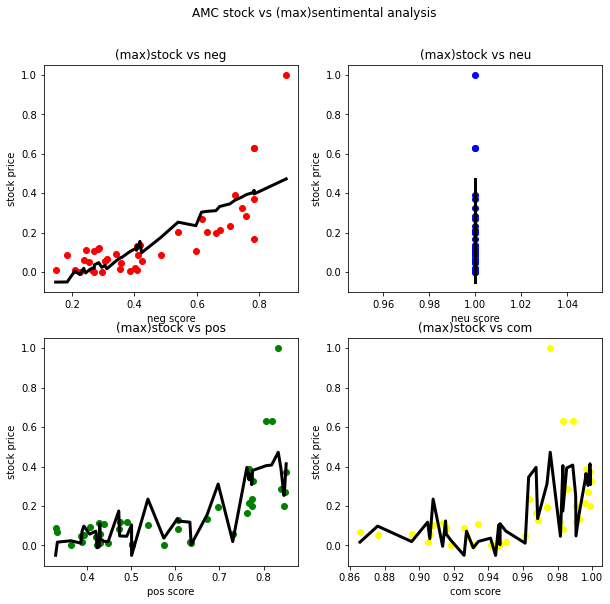

In [22]:
#Max sentimental analysis
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('AMC stock vs (max)sentimental analysis')
fig.set_size_inches(10,8)

amc_sort_neg_max = amc_merge_pred_max.sort_values(by=['neg'])
axs[0,0].scatter(amc_sort_neg_max[['neg']],amc_sort_neg_max[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(amc_sort_neg_max[['neg']], amc_sort_neg_max[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('(max)stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

amc_sort_neu_max = amc_merge_pred_max.sort_values(by=['neu'])
axs[0,1].scatter(amc_sort_neu_max[['neu']],amc_sort_neu_max[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(amc_sort_neu_max[['neu']], amc_sort_neu_max[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('(max)stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

amc_sort_pos_max = amc_merge_pred_max.sort_values(by=['pos'])
axs[1,0].scatter(amc_sort_pos_max[['pos']],amc_sort_pos_max[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(amc_sort_pos_max[['pos']], amc_sort_pos_max[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('(max)stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

amc_sort_com_max = amc_merge_pred_max.sort_values(by=['com'])
axs[1,1].scatter(amc_sort_com_max[['com']],amc_sort_com_max[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(amc_sort_com_max[['com']], amc_sort_com_max[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('(max)stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

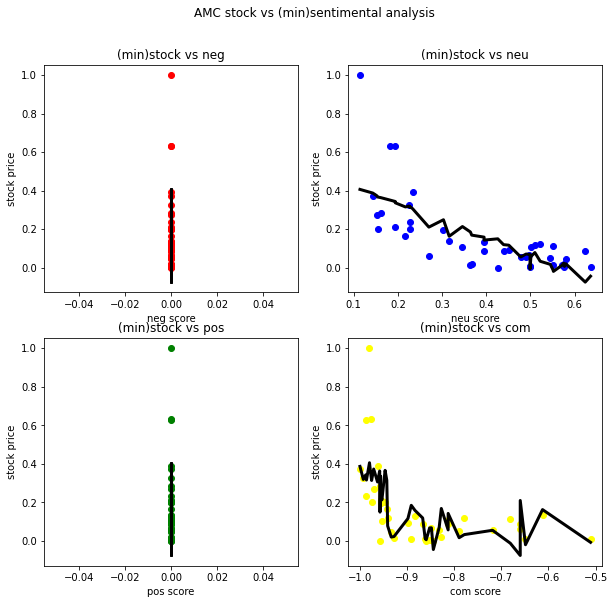

In [23]:
#Min sentimental analysis
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('AMC stock vs (min)sentimental analysis')
fig.set_size_inches(10,8)

amc_sort_neg_min = amc_merge_pred_min.sort_values(by=['neg'])
axs[0,0].scatter(amc_sort_neg_min[['neg']],amc_sort_neg_min[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(amc_sort_neg_min[['neg']], amc_sort_neg_min[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('(min)stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

amc_sort_neu_min = amc_merge_pred_min.sort_values(by=['neu'])
axs[0,1].scatter(amc_sort_neu_min[['neu']],amc_sort_neu_min[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(amc_sort_neu_min[['neu']], amc_sort_neu_min[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('(min)stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

amc_sort_pos_min = amc_merge_pred_min.sort_values(by=['pos'])
axs[1,0].scatter(amc_sort_pos_min[['pos']],amc_sort_pos_min[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(amc_sort_pos_min[['pos']], amc_sort_pos_min[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('(min)stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

amc_sort_com_min = amc_merge_pred_min.sort_values(by=['com'])
axs[1,1].scatter(amc_sort_com_min[['com']],amc_sort_com_min[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(amc_sort_com_min[['com']], amc_sort_com_min[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('(min)stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

# Plot data against time

Plotting AMC stock with mean sentimental analysis


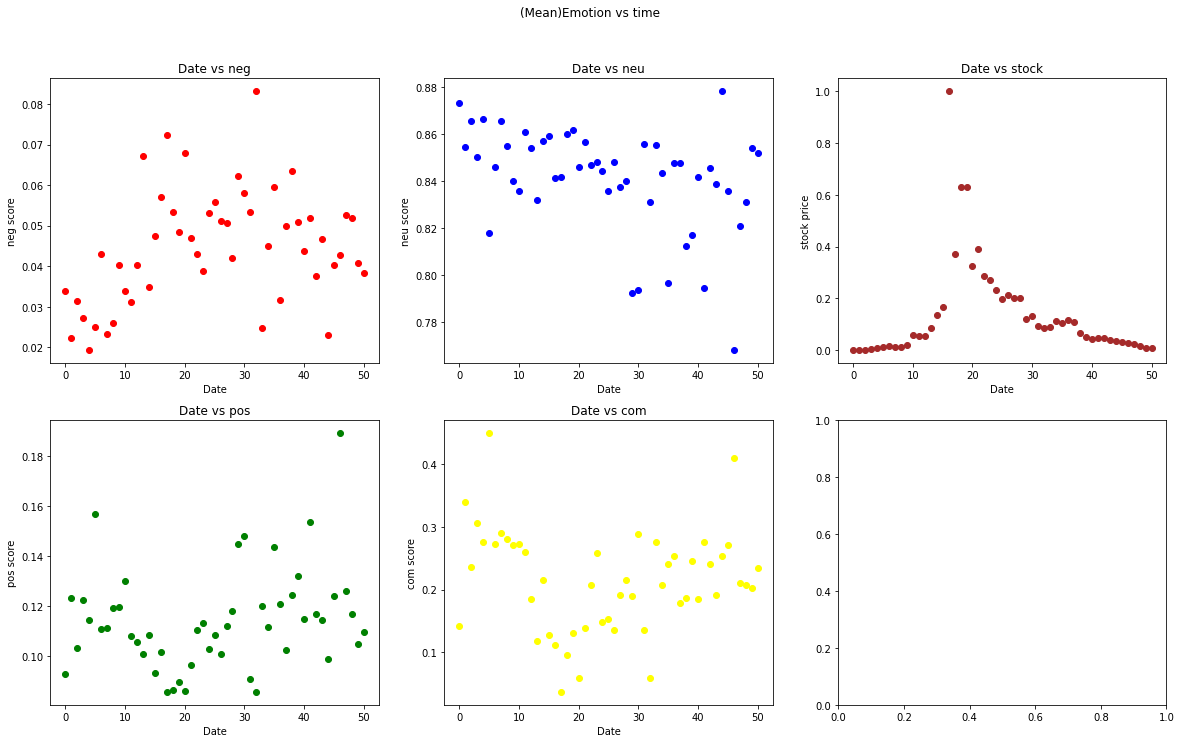

In [24]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(Mean)Emotion vs time')
fig.set_size_inches(20,10)

amc_sort_neg_mean = amc_merge_df_mean.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(amc_sort_neg_mean.shape[0])],amc_sort_neg_mean[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

amc_sort_neu_mean = amc_merge_df_mean.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(amc_sort_neu_mean.shape[0])],amc_sort_neu_mean[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

amc_sort_pos_mean = amc_merge_df_mean.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(amc_sort_pos_mean.shape[0])],amc_sort_pos_mean[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

amc_sort_com_mean = amc_merge_df_mean.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(amc_sort_com_mean.shape[0])],amc_sort_com_mean[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

amc_sort_date = amc_merge_df_mean.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(amc_sort_date.shape[0])],amc_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

In [25]:
amc_sort_neg_mean.shape[0]

51

Plotting AMC stock with median sentimental analysis

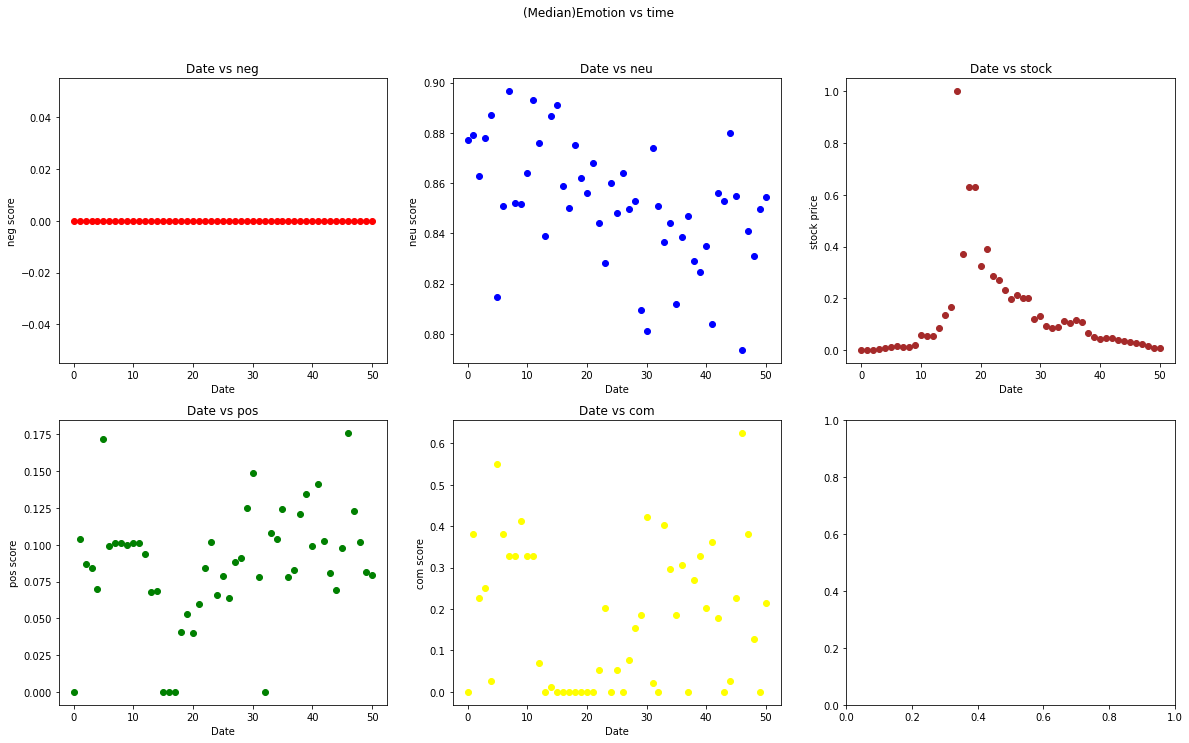

In [26]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(Median)Emotion vs time')
fig.set_size_inches(20,10)

amc_sort_neg_median = amc_merge_df_median.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(amc_sort_neg_median.shape[0])],amc_sort_neg_median[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

amc_sort_neu_median = amc_merge_df_median.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(amc_sort_neu_median.shape[0])],amc_sort_neu_median[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

amc_sort_pos_median = amc_merge_df_median.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(amc_sort_pos_median.shape[0])],amc_sort_pos_median[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

amc_sort_com_median = amc_merge_df_median.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(amc_sort_com_median.shape[0])],amc_sort_com_median[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

amc_sort_date = amc_merge_df_median.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(amc_sort_date.shape[0])],amc_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

Plotting AMC stock with std sentimental analysis

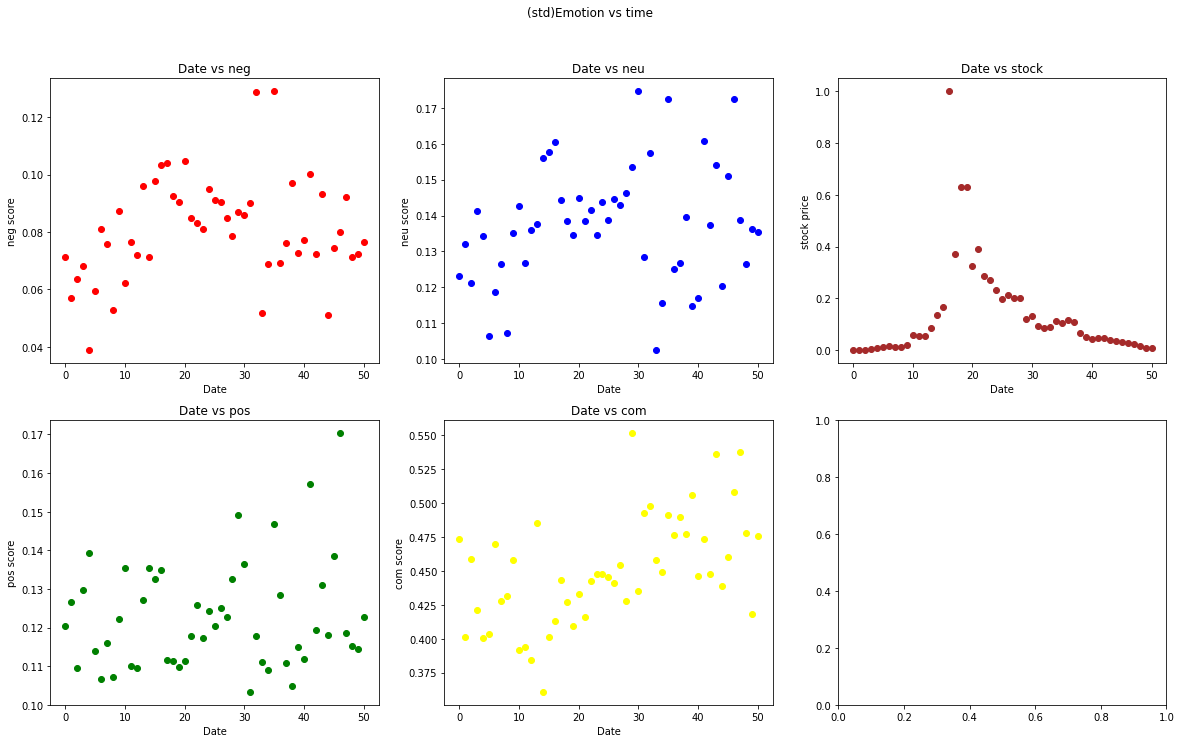

In [27]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(std)Emotion vs time')
fig.set_size_inches(20,10)

amc_sort_neg_std = amc_merge_df_std.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(amc_sort_neg_std.shape[0])],amc_sort_neg_std[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

amc_sort_neu_std = amc_merge_df_std.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(amc_sort_neu_std.shape[0])],amc_sort_neu_std[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

amc_sort_pos_std = amc_merge_df_std.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(amc_sort_pos_std.shape[0])],amc_sort_pos_std[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

amc_sort_com_std = amc_merge_df_std.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(amc_sort_com_std.shape[0])],amc_sort_com_std[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

amc_sort_date = amc_merge_df_std.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(amc_sort_date.shape[0])],amc_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

Plotting AMC stock with maximum sentimental analysis

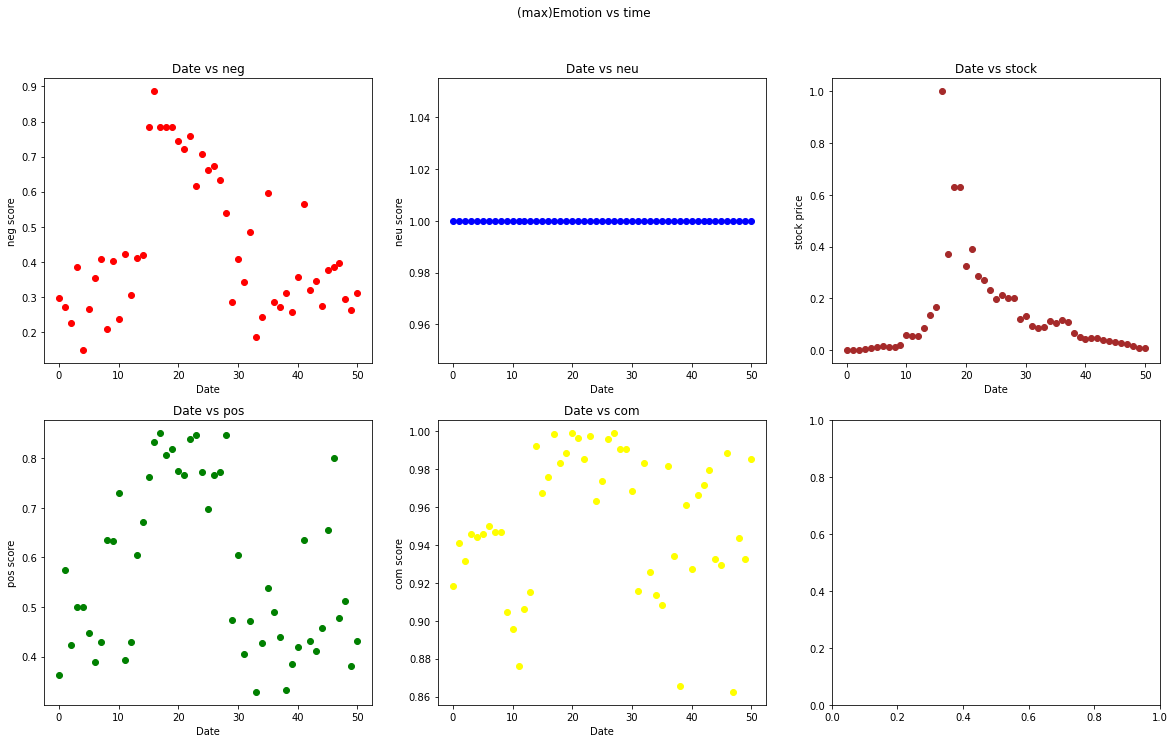

In [28]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(max)Emotion vs time')
fig.set_size_inches(20,10)

amc_sort_neg_max = amc_merge_df_max.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(amc_sort_neg_max.shape[0])],amc_sort_neg_max[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

amc_sort_neu_max = amc_merge_df_max.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(amc_sort_neu_max.shape[0])],amc_sort_neu_max[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

amc_sort_pos_max = amc_merge_df_max.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(amc_sort_pos_max.shape[0])],amc_sort_pos_max[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

amc_sort_com_max = amc_merge_df_max.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(amc_sort_com_max.shape[0])],amc_sort_com_max[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

amc_sort_date = amc_merge_df_max.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(amc_sort_date.shape[0])],amc_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

Plotting AMC stock with minimum sentimental analysis

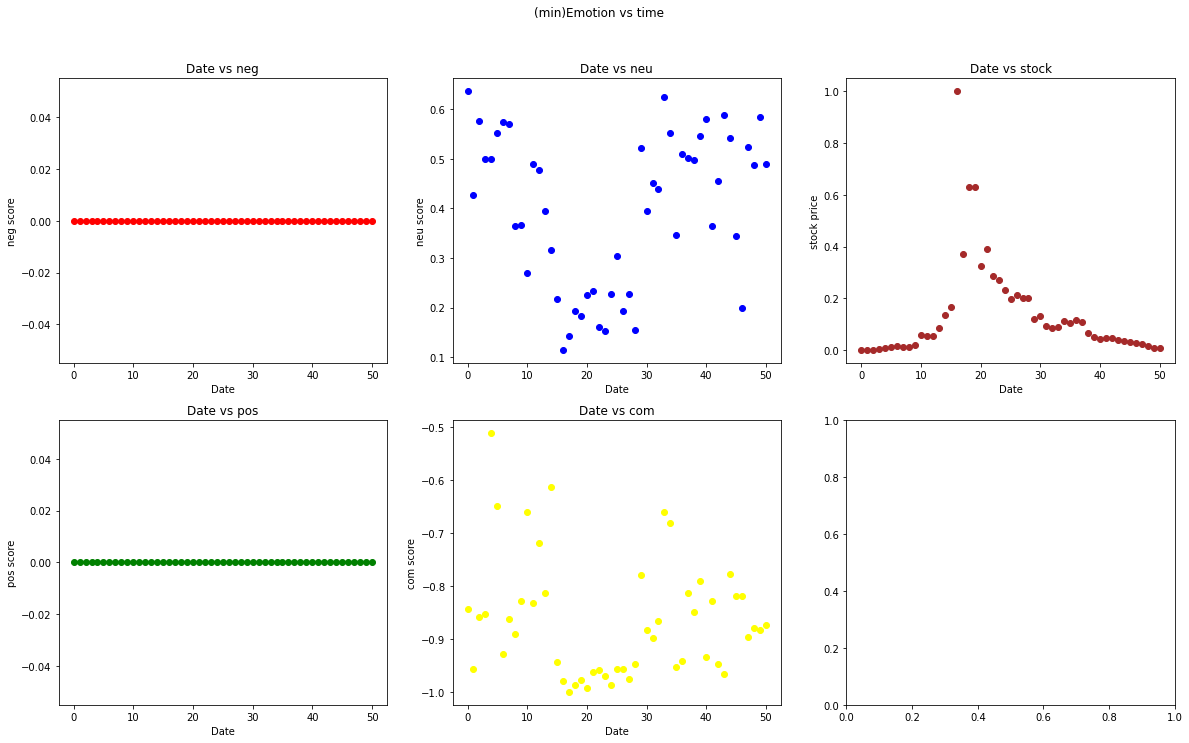

In [29]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(min)Emotion vs time')
fig.set_size_inches(20,10)

amc_sort_neg_min = amc_merge_df_min.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(amc_sort_neg_min.shape[0])],amc_sort_neg_min[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

amc_sort_neu_min = amc_merge_df_min.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(amc_sort_neu_min.shape[0])],amc_sort_neu_min[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

amc_sort_pos_min = amc_merge_df_min.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(amc_sort_pos_min.shape[0])],amc_sort_pos_min[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

amc_sort_com_min = amc_merge_df_min.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(amc_sort_com_min.shape[0])],amc_sort_com_min[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

amc_sort_date = amc_merge_df_min.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(amc_sort_date.shape[0])],amc_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

# Training with different method

Training with mean sentimental analysis

In [30]:
#Training models based on the amc data for four features(neg,neu,pos,com) separately
reg_amc_neg_mean = LinearRegression().fit(amc_merge_df_mean[['neg']][:-10], amc_merge_df_mean[['close']][:-10])
reg_amc_neu_mean = LinearRegression().fit(amc_merge_df_mean[['neu']][:-10], amc_merge_df_mean[['close']][:-10])
reg_amc_pos_mean = LinearRegression().fit(amc_merge_df_mean[['pos']][:-10], amc_merge_df_mean[['close']][:-10])
reg_amc_com_mean = LinearRegression().fit(amc_merge_df_mean[['com']][:-10], amc_merge_df_mean[['close']][:-10])

In [31]:
#predict the stock price of amc using new models
pred_amc_neg_mean = reg_amc_neg_mean.predict(amc_merge_df_mean[['neg']][-10:])
pred_amc_neu_mean = reg_amc_neu_mean.predict(amc_merge_df_mean[['neu']][-10:])
pred_amc_pos_mean = reg_amc_pos_mean.predict(amc_merge_df_mean[['pos']][-10:])
pred_amc_com_mean = reg_amc_com_mean.predict(amc_merge_df_mean[['com']][-10:])

#predict on the training model to plot the data
train_amc_neg_mean = reg_amc_neg_mean.predict(amc_merge_df_mean[['neg']][:-10])
train_amc_neu_mean = reg_amc_neu_mean.predict(amc_merge_df_mean[['neu']][:-10])
train_amc_pos_mean = reg_amc_pos_mean.predict(amc_merge_df_mean[['pos']][:-10])
train_amc_com_mean = reg_amc_com_mean.predict(amc_merge_df_mean[['com']][:-10])

#combine five kinds of prediction for amc with original data
amc_merge_pred1_mean = pd.concat([amc_merge_df_mean[:-10], pd.DataFrame(train_amc_neg_mean,columns=['pred_neg'])], axis=1)
amc_merge_pred1_mean = pd.concat([amc_merge_pred1_mean, pd.DataFrame(train_amc_neu_mean,columns=['pred_neu'])], axis=1)
amc_merge_pred1_mean = pd.concat([amc_merge_pred1_mean, pd.DataFrame(train_amc_pos_mean,columns=['pred_pos'])], axis=1)
amc_merge_pred1_mean = pd.concat([amc_merge_pred1_mean, pd.DataFrame(train_amc_com_mean,columns=['pred_com'])], axis=1)

amc_merge_pred1_mean

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.033829,0.873171,0.093024,0.141173,0.001674,0.105481,0.188948,0.253480,0.245609
1,01/05/2021,0.022333,0.854451,0.123235,0.340204,0.000000,0.046422,0.173271,0.107315,-0.011879
2,01/06/2021,0.031537,0.865293,0.103171,0.235988,0.001674,0.093703,0.182350,0.204391,0.122946
3,01/07/2021,0.027321,0.850094,0.122566,0.306055,0.003906,0.072044,0.169622,0.110553,0.032300
4,01/08/2021,0.019286,0.866257,0.114486,0.276603,0.008929,0.030765,0.183158,0.149647,0.070402
5,01/11/2021,0.025086,0.818069,0.156879,0.450245,0.012277,0.060565,0.142802,-0.055460,-0.154240
6,01/12/2021,0.043082,0.845902,0.110967,0.273641,0.017299,0.153015,0.166111,0.166670,0.074234
7,01/13/2021,0.023346,0.865288,0.111404,0.291133,0.011161,0.051625,0.182347,0.164557,0.051605
8,01/14/2021,0.026014,0.854771,0.119157,0.281360,0.011161,0.065332,0.173539,0.127046,0.064248
9,01/15/2021,0.040222,0.840111,0.119667,0.271243,0.019531,0.138324,0.161262,0.124581,0.077336


In [32]:
amc_score_neg_mean = mean_squared_error(amc_merge_df_mean[['close']][-10:], pred_amc_neg_mean)
amc_score_neu_mean = mean_squared_error(amc_merge_df_mean[['close']][-10:], pred_amc_neu_mean)
amc_score_pos_mean = mean_squared_error(amc_merge_df_mean[['close']][-10:], pred_amc_pos_mean)
amc_score_com_mean = mean_squared_error(amc_merge_df_mean[['close']][-10:], pred_amc_com_mean)
[amc_score_neg_mean,amc_score_neu_mean,amc_score_pos_mean,amc_score_com_mean]

[0.01691898844171275,
 0.016756823566653867,
 0.02091500489072103,
 0.01254787027240738]

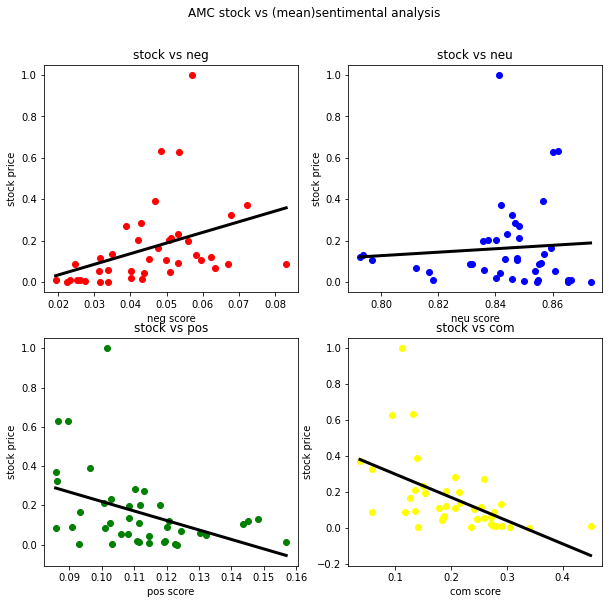

In [33]:
#plot the new amc model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('AMC stock vs (mean)sentimental analysis')
fig.set_size_inches(10,8)

amc_sort_neg_mean = amc_merge_pred1_mean.sort_values(by=['neg'])
axs[0,0].scatter(amc_sort_neg_mean[['neg']],amc_sort_neg_mean[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(amc_sort_neg_mean[['neg']], amc_sort_neg_mean[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

amc_sort_neu_mean = amc_merge_pred1_mean.sort_values(by=['neu'])
axs[0,1].scatter(amc_sort_neu_mean[['neu']],amc_sort_neu_mean[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(amc_sort_neu_mean[['neu']], amc_sort_neu_mean[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

amc_sort_pos_mean = amc_merge_pred1_mean.sort_values(by=['pos'])
axs[1,0].scatter(amc_sort_pos_mean[['pos']],amc_sort_pos_mean[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(amc_sort_pos_mean[['pos']], amc_sort_pos_mean[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

amc_sort_com_mean = amc_merge_pred1_mean.sort_values(by=['com'])
axs[1,1].scatter(amc_sort_com_mean[['com']],amc_sort_com_mean[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(amc_sort_com_mean[['com']], amc_sort_com_mean[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

Training with median sentimental analysis

In [34]:
#Training models based on the amc data for four features(neg,neu,pos,com) separately
reg_amc_neg_median = LinearRegression().fit(amc_merge_df_median[['neg']][:-10], amc_merge_df_median[['close']][:-10])
reg_amc_neu_median = LinearRegression().fit(amc_merge_df_median[['neu']][:-10], amc_merge_df_median[['close']][:-10])
reg_amc_pos_median = LinearRegression().fit(amc_merge_df_median[['pos']][:-10], amc_merge_df_median[['close']][:-10])
reg_amc_com_median = LinearRegression().fit(amc_merge_df_median[['com']][:-10], amc_merge_df_median[['close']][:-10])

In [35]:
#predict the stock price of amc using new models
pred_amc_neg_median = reg_amc_neg_median.predict(amc_merge_df_median[['neg']][-10:])
pred_amc_neu_median = reg_amc_neu_median.predict(amc_merge_df_median[['neu']][-10:])
pred_amc_pos_median = reg_amc_pos_median.predict(amc_merge_df_median[['pos']][-10:])
pred_amc_com_median = reg_amc_com_median.predict(amc_merge_df_median[['com']][-10:])

#predict on the training model to plot the data
train_amc_neg_median = reg_amc_neg_median.predict(amc_merge_df_median[['neg']][:-10])
train_amc_neu_median = reg_amc_neu_median.predict(amc_merge_df_median[['neu']][:-10])
train_amc_pos_median = reg_amc_pos_median.predict(amc_merge_df_median[['pos']][:-10])
train_amc_com_median = reg_amc_com_median.predict(amc_merge_df_median[['com']][:-10])

#combine five kinds of prediction for amc with original data
amc_merge_pred1_median = pd.concat([amc_merge_df_median[:-10], pd.DataFrame(train_amc_neg_median,columns=['pred_neg'])], axis=1)
amc_merge_pred1_median = pd.concat([amc_merge_pred1_median, pd.DataFrame(train_amc_neu_median,columns=['pred_neu'])], axis=1)
amc_merge_pred1_median = pd.concat([amc_merge_pred1_median, pd.DataFrame(train_amc_pos_median,columns=['pred_pos'])], axis=1)
amc_merge_pred1_median = pd.concat([amc_merge_pred1_median, pd.DataFrame(train_amc_com_median,columns=['pred_com'])], axis=1)

amc_merge_pred1_median

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.0,0.8770,0.0000,0.00000,0.001674,0.163899,0.172047,0.366773,0.265479
1,01/05/2021,0.0,0.8790,0.1040,0.38180,0.000000,0.163899,0.172758,0.106410,0.030975
2,01/06/2021,0.0,0.8630,0.0870,0.22630,0.001674,0.163899,0.167069,0.148970,0.126484
3,01/07/2021,0.0,0.8780,0.0840,0.25000,0.003906,0.163899,0.172403,0.156480,0.111927
4,01/08/2021,0.0,0.8870,0.0700,0.02580,0.008929,0.163899,0.175603,0.191529,0.249633
5,01/11/2021,0.0,0.8145,0.1720,0.54985,0.012277,0.163899,0.149824,-0.063827,-0.072243
6,01/12/2021,0.0,0.8510,0.0990,0.38040,0.017299,0.163899,0.162802,0.118928,0.031835
7,01/13/2021,0.0,0.8965,0.1010,0.32910,0.011161,0.163899,0.178981,0.113921,0.063344
8,01/14/2021,0.0,0.8520,0.1010,0.32910,0.011161,0.163899,0.163158,0.113921,0.063344
9,01/15/2021,0.0,0.8515,0.1000,0.41170,0.019531,0.163899,0.162980,0.116424,0.012610


In [36]:
amc_score_neg_median = mean_squared_error(amc_merge_df_median[['close']][-10:], pred_amc_neg_median)
amc_score_neu_median = mean_squared_error(amc_merge_df_median[['close']][-10:], pred_amc_neu_median)
amc_score_pos_median = mean_squared_error(amc_merge_df_median[['close']][-10:], pred_amc_pos_median)
amc_score_com_median = mean_squared_error(amc_merge_df_median[['close']][-10:], pred_amc_com_median)
[amc_score_neg_median,amc_score_neu_median,amc_score_pos_median,amc_score_com_median]

[0.0184466410870559,
 0.017389773558190786,
 0.012423536504635208,
 0.025065632905276115]

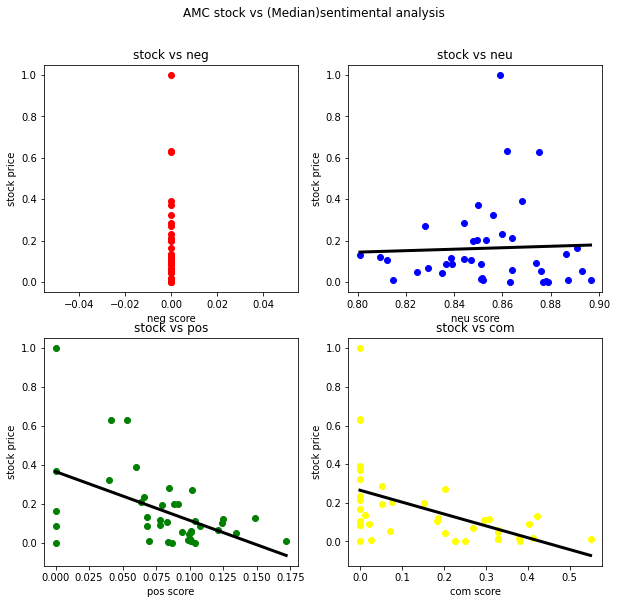

In [37]:
#plot the new amc model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('AMC stock vs (Median)sentimental analysis')
fig.set_size_inches(10,8)

amc_sort_neg_median = amc_merge_pred1_median.sort_values(by=['neg'])
axs[0,0].scatter(amc_sort_neg_median[['neg']],amc_sort_neg_median[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(amc_sort_neg_median[['neg']], amc_sort_neg_median[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

amc_sort_neu_median = amc_merge_pred1_median.sort_values(by=['neu'])
axs[0,1].scatter(amc_sort_neu_median[['neu']],amc_sort_neu_median[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(amc_sort_neu_median[['neu']], amc_sort_neu_median[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

amc_sort_pos_median = amc_merge_pred1_median.sort_values(by=['pos'])
axs[1,0].scatter(amc_sort_pos_median[['pos']],amc_sort_pos_median[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(amc_sort_pos_median[['pos']], amc_sort_pos_median[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

amc_sort_com_median = amc_merge_pred1_median.sort_values(by=['com'])
axs[1,1].scatter(amc_sort_com_median[['com']],amc_sort_com_median[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(amc_sort_com_median[['com']], amc_sort_com_median[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

Training with std sentimental analysis

In [38]:
#Training models based on the amc data for four features(neg,neu,pos,com) separately
reg_amc_neg_std = LinearRegression().fit(amc_merge_df_std[['neg']][:-10], amc_merge_df_std[['close']][:-10])
reg_amc_neu_std = LinearRegression().fit(amc_merge_df_std[['neu']][:-10], amc_merge_df_std[['close']][:-10])
reg_amc_pos_std = LinearRegression().fit(amc_merge_df_std[['pos']][:-10], amc_merge_df_std[['close']][:-10])
reg_amc_com_std = LinearRegression().fit(amc_merge_df_std[['com']][:-10], amc_merge_df_std[['close']][:-10])

In [39]:
#predict the stock price of amc using new models
pred_amc_neg_std = reg_amc_neg_std.predict(amc_merge_df_std[['neg']][-10:])
pred_amc_neu_std = reg_amc_neu_std.predict(amc_merge_df_std[['neu']][-10:])
pred_amc_pos_std = reg_amc_pos_std.predict(amc_merge_df_std[['pos']][-10:])
pred_amc_com_std = reg_amc_com_std.predict(amc_merge_df_std[['com']][-10:])

#predict on the training model to plot the data
train_amc_neg_std = reg_amc_neg_std.predict(amc_merge_df_std[['neg']][:-10])
train_amc_neu_std = reg_amc_neu_std.predict(amc_merge_df_std[['neu']][:-10])
train_amc_pos_std = reg_amc_pos_std.predict(amc_merge_df_std[['pos']][:-10])
train_amc_com_std = reg_amc_com_std.predict(amc_merge_df_std[['com']][:-10])

#combine five kinds of prediction for amc with original data
amc_merge_pred1_std = pd.concat([amc_merge_df_std[:-10], pd.DataFrame(train_amc_neg_std,columns=['pred_neg'])], axis=1)
amc_merge_pred1_std = pd.concat([amc_merge_pred1_std, pd.DataFrame(train_amc_neu_std,columns=['pred_neu'])], axis=1)
amc_merge_pred1_std = pd.concat([amc_merge_pred1_std, pd.DataFrame(train_amc_pos_std,columns=['pred_pos'])], axis=1)
amc_merge_pred1_std = pd.concat([amc_merge_pred1_std, pd.DataFrame(train_amc_com_std,columns=['pred_com'])], axis=1)

amc_merge_pred1_std

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.071258,0.123040,0.120420,0.473159,0.001674,0.116140,0.105825,0.163601,0.134758
1,01/05/2021,0.056878,0.131948,0.126705,0.401204,0.000000,0.050378,0.145196,0.169081,0.205156
2,01/06/2021,0.063570,0.121238,0.109421,0.458876,0.001674,0.080982,0.097857,0.154011,0.148732
3,01/07/2021,0.068162,0.141396,0.129706,0.421182,0.003906,0.101980,0.186959,0.171698,0.185610
4,01/08/2021,0.038832,0.134296,0.139287,0.400202,0.008929,-0.032148,0.155577,0.180052,0.206137
5,01/11/2021,0.059576,0.106439,0.113913,0.403111,0.012277,0.062718,0.032447,0.157928,0.203291
6,01/12/2021,0.081018,0.118667,0.106749,0.470027,0.017299,0.160771,0.086492,0.151681,0.137823
7,01/13/2021,0.075847,0.126564,0.115866,0.427937,0.011161,0.137123,0.121401,0.159630,0.179002
8,01/14/2021,0.052916,0.107322,0.107070,0.431100,0.011161,0.032260,0.036347,0.151961,0.175908
9,01/15/2021,0.087321,0.135113,0.122276,0.457611,0.019531,0.189597,0.159186,0.165219,0.149970


In [40]:
amc_score_neg_std = mean_squared_error(amc_merge_df_std[['close']][-10:], pred_amc_neg_std)
amc_score_neu_std = mean_squared_error(amc_merge_df_std[['close']][-10:], pred_amc_neu_std)
amc_score_pos_std = mean_squared_error(amc_merge_df_std[['close']][-10:], pred_amc_pos_std)
amc_score_com_std = mean_squared_error(amc_merge_df_std[['close']][-10:], pred_amc_com_std)
[amc_score_neg_std,amc_score_neu_std,amc_score_pos_std,amc_score_com_std]

[0.017875184934532308,
 0.03173932975101043,
 0.020894166211718135,
 0.012010135061284413]

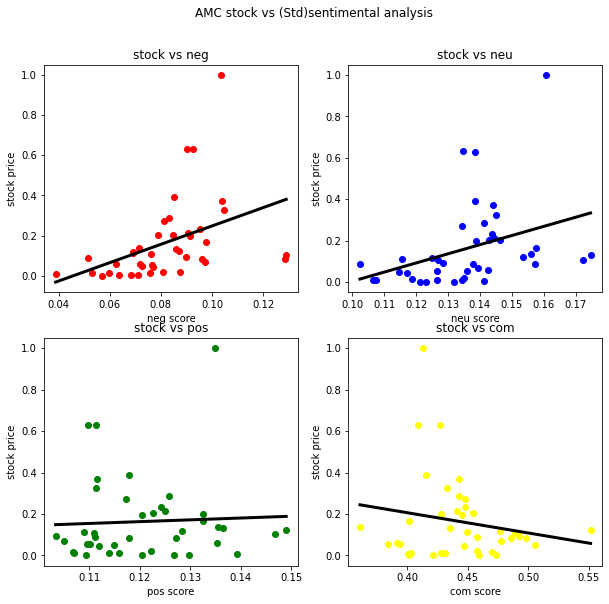

In [41]:
#plot the new amc model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('AMC stock vs (Std)sentimental analysis')
fig.set_size_inches(10,8)

amc_sort_neg_std = amc_merge_pred1_std.sort_values(by=['neg'])
axs[0,0].scatter(amc_sort_neg_std[['neg']],amc_sort_neg_std[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(amc_sort_neg_std[['neg']], amc_sort_neg_std[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

amc_sort_neu_std = amc_merge_pred1_std.sort_values(by=['neu'])
axs[0,1].scatter(amc_sort_neu_std[['neu']],amc_sort_neu_std[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(amc_sort_neu_std[['neu']], amc_sort_neu_std[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

amc_sort_pos_std = amc_merge_pred1_std.sort_values(by=['pos'])
axs[1,0].scatter(amc_sort_pos_std[['pos']],amc_sort_pos_std[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(amc_sort_pos_std[['pos']], amc_sort_pos_std[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

amc_sort_com_std = amc_merge_pred1_std.sort_values(by=['com'])
axs[1,1].scatter(amc_sort_com_std[['com']],amc_sort_com_std[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(amc_sort_com_std[['com']], amc_sort_com_std[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

Training with maximum sentimental analysis

In [42]:
#Training models based on the amc data for four features(neg,neu,pos,com) separately
reg_amc_neg_max = LinearRegression().fit(amc_merge_df_max[['neg']][:-10], amc_merge_df_max[['close']][:-10])
reg_amc_neu_max = LinearRegression().fit(amc_merge_df_max[['neu']][:-10], amc_merge_df_max[['close']][:-10])
reg_amc_pos_max = LinearRegression().fit(amc_merge_df_max[['pos']][:-10], amc_merge_df_max[['close']][:-10])
reg_amc_com_max = LinearRegression().fit(amc_merge_df_max[['com']][:-10], amc_merge_df_max[['close']][:-10])

In [43]:
#predict the stock price of amc using new models
pred_amc_neg_max = reg_amc_neg_max.predict(amc_merge_df_max[['neg']][-10:])
pred_amc_neu_max = reg_amc_neu_max.predict(amc_merge_df_max[['neu']][-10:])
pred_amc_pos_max = reg_amc_pos_max.predict(amc_merge_df_max[['pos']][-10:])
pred_amc_com_max = reg_amc_com_max.predict(amc_merge_df_max[['com']][-10:])

#predict on the training model to plot the data
train_amc_neg_max = reg_amc_neg_max.predict(amc_merge_df_max[['neg']][:-10])
train_amc_neu_max = reg_amc_neu_max.predict(amc_merge_df_max[['neu']][:-10])
train_amc_pos_max = reg_amc_pos_max.predict(amc_merge_df_max[['pos']][:-10])
train_amc_com_max = reg_amc_com_max.predict(amc_merge_df_max[['com']][:-10])

#combine five kinds of prediction for amc with original data
amc_merge_pred1_max = pd.concat([amc_merge_df_max[:-10], pd.DataFrame(train_amc_neg_max,columns=['pred_neg'])], axis=1)
amc_merge_pred1_max = pd.concat([amc_merge_pred1_max, pd.DataFrame(train_amc_neu_max,columns=['pred_neu'])], axis=1)
amc_merge_pred1_max = pd.concat([amc_merge_pred1_max, pd.DataFrame(train_amc_pos_max,columns=['pred_pos'])], axis=1)
amc_merge_pred1_max = pd.concat([amc_merge_pred1_max, pd.DataFrame(train_amc_com_max,columns=['pred_com'])], axis=1)

amc_merge_pred1_max

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.296,1.0,0.364,0.9186,0.001674,0.041069,0.163899,-0.011318,0.069107
1,01/05/2021,0.272,1.0,0.574,0.9413,0.000000,0.023096,0.163899,0.151266,0.132559
2,01/06/2021,0.226,1.0,0.423,0.9313,0.001674,-0.011351,0.163899,0.034361,0.104606
3,01/07/2021,0.386,1.0,0.501,0.9460,0.003906,0.108466,0.163899,0.094749,0.145696
4,01/08/2021,0.148,1.0,0.501,0.9442,0.008929,-0.069761,0.163899,0.094749,0.140665
5,01/11/2021,0.265,1.0,0.448,0.9460,0.012277,0.017854,0.163899,0.053716,0.145696
6,01/12/2021,0.355,1.0,0.389,0.9501,0.017299,0.085251,0.163899,0.008038,0.157157
7,01/13/2021,0.407,1.0,0.429,0.9468,0.011161,0.124192,0.163899,0.039006,0.147932
8,01/14/2021,0.209,1.0,0.636,0.9468,0.011161,-0.024081,0.163899,0.199267,0.147932
9,01/15/2021,0.402,1.0,0.633,0.9049,0.019531,0.120447,0.163899,0.196945,0.030812


In [44]:
amc_score_neg_max = mean_squared_error(amc_merge_df_max[['close']][-10:], pred_amc_neg_max)
amc_score_neu_max = mean_squared_error(amc_merge_df_max[['close']][-10:], pred_amc_neu_max)
amc_score_pos_max = mean_squared_error(amc_merge_df_max[['close']][-10:], pred_amc_pos_max)
amc_score_com_max = mean_squared_error(amc_merge_df_max[['close']][-10:], pred_amc_com_max)
[amc_score_neg_max,amc_score_neu_max,amc_score_pos_max,amc_score_com_max]

[0.006155979200579163,
 0.0184466410870559,
 0.015667451696779962,
 0.025684400021913904]

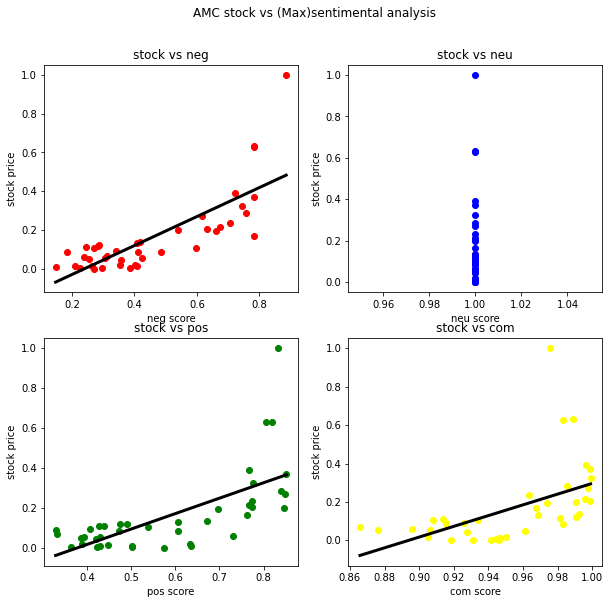

In [45]:
#plot the new amc model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('AMC stock vs (Max)sentimental analysis')
fig.set_size_inches(10,8)

amc_sort_neg_max = amc_merge_pred1_max.sort_values(by=['neg'])
axs[0,0].scatter(amc_sort_neg_max[['neg']],amc_sort_neg_max[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(amc_sort_neg_max[['neg']], amc_sort_neg_max[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

amc_sort_neu_max = amc_merge_pred1_max.sort_values(by=['neu'])
axs[0,1].scatter(amc_sort_neu_max[['neu']],amc_sort_neu_max[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(amc_sort_neu_max[['neu']], amc_sort_neu_max[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

amc_sort_pos_max = amc_merge_pred1_max.sort_values(by=['pos'])
axs[1,0].scatter(amc_sort_pos_max[['pos']],amc_sort_pos_max[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(amc_sort_pos_max[['pos']], amc_sort_pos_max[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

amc_sort_com_max = amc_merge_pred1_max.sort_values(by=['com'])
axs[1,1].scatter(amc_sort_com_max[['com']],amc_sort_com_max[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(amc_sort_com_max[['com']], amc_sort_com_max[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

Training with minimum sentimental analysis

In [46]:
#Training models based on the amc data for four features(neg,neu,pos,com) separately
reg_amc_neg_min = LinearRegression().fit(amc_merge_df_min[['neg']][:-10], amc_merge_df_min[['close']][:-10])
reg_amc_neu_min = LinearRegression().fit(amc_merge_df_min[['neu']][:-10], amc_merge_df_min[['close']][:-10])
reg_amc_pos_min = LinearRegression().fit(amc_merge_df_min[['pos']][:-10], amc_merge_df_min[['close']][:-10])
reg_amc_com_min = LinearRegression().fit(amc_merge_df_min[['com']][:-10], amc_merge_df_min[['close']][:-10])

In [47]:
#predict the stock price of amc using new models
pred_amc_neg_min = reg_amc_neg_min.predict(amc_merge_df_min[['neg']][-10:])
pred_amc_neu_min = reg_amc_neu_min.predict(amc_merge_df_min[['neu']][-10:])
pred_amc_pos_min = reg_amc_pos_min.predict(amc_merge_df_min[['pos']][-10:])
pred_amc_com_min = reg_amc_com_min.predict(amc_merge_df_min[['com']][-10:])

#predict on the training model to plot the data
train_amc_neg_min = reg_amc_neg_min.predict(amc_merge_df_min[['neg']][:-10])
train_amc_neu_min = reg_amc_neu_min.predict(amc_merge_df_min[['neu']][:-10])
train_amc_pos_min = reg_amc_pos_min.predict(amc_merge_df_min[['pos']][:-10])
train_amc_com_min = reg_amc_com_min.predict(amc_merge_df_min[['com']][:-10])

#combine five kinds of prediction for amc with original data
amc_merge_pred1_min = pd.concat([amc_merge_df_min[:-10], pd.DataFrame(train_amc_neg_min,columns=['pred_neg'])], axis=1)
amc_merge_pred1_min = pd.concat([amc_merge_pred1_min, pd.DataFrame(train_amc_neu_min,columns=['pred_neu'])], axis=1)
amc_merge_pred1_min = pd.concat([amc_merge_pred1_min, pd.DataFrame(train_amc_pos_min,columns=['pred_pos'])], axis=1)
amc_merge_pred1_min = pd.concat([amc_merge_pred1_min, pd.DataFrame(train_amc_com_min,columns=['pred_com'])], axis=1)

amc_merge_pred1_min

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.0,0.636,0.0,-0.8440,0.001674,0.163899,-0.062988,0.163899,0.147690
1,01/05/2021,0.0,0.426,0.0,-0.9571,0.000000,0.163899,0.125319,0.163899,0.237192
2,01/06/2021,0.0,0.577,0.0,-0.8591,0.001674,0.163899,-0.010083,0.163899,0.159639
3,01/07/2021,0.0,0.499,0.0,-0.8519,0.003906,0.163899,0.059860,0.163899,0.153942
4,01/08/2021,0.0,0.499,0.0,-0.5106,0.008929,0.163899,0.059860,0.163899,-0.116145
5,01/11/2021,0.0,0.552,0.0,-0.6486,0.012277,0.163899,0.012335,0.163899,-0.006939
6,01/12/2021,0.0,0.575,0.0,-0.9274,0.017299,0.163899,-0.008289,0.163899,0.213688
7,01/13/2021,0.0,0.571,0.0,-0.8613,0.011161,0.163899,-0.004702,0.163899,0.161380
8,01/14/2021,0.0,0.364,0.0,-0.8908,0.011161,0.163899,0.180915,0.163899,0.184725
9,01/15/2021,0.0,0.367,0.0,-0.8271,0.019531,0.163899,0.178225,0.163899,0.134316


In [48]:
amc_score_neg_min = mean_squared_error(amc_merge_df_min[['close']][-10:], pred_amc_neg_min)
amc_score_neu_min = mean_squared_error(amc_merge_df_min[['close']][-10:], pred_amc_neu_min)
amc_score_pos_min = mean_squared_error(amc_merge_df_min[['close']][-10:], pred_amc_pos_min)
amc_score_com_min = mean_squared_error(amc_merge_df_min[['close']][-10:], pred_amc_com_min)
[amc_score_neg_min,amc_score_neu_min,amc_score_pos_min,amc_score_com_min]

[0.0184466410870559,
 0.01485792066746503,
 0.0184466410870559,
 0.021306625511390283]

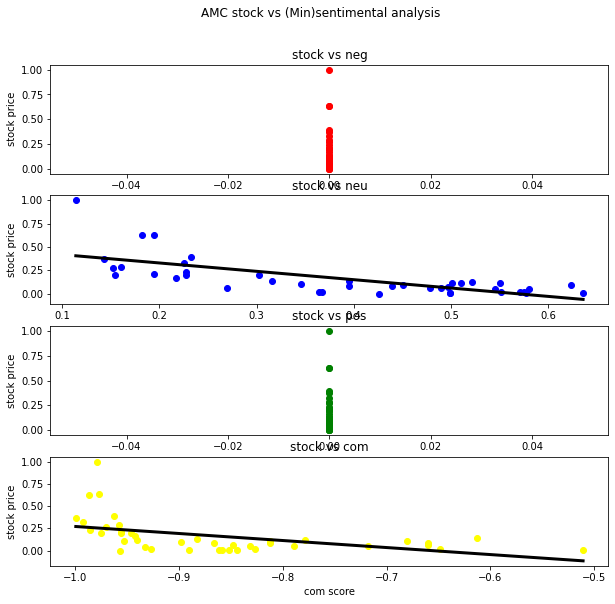

In [49]:
#plot the new amc model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(4)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('AMC stock vs (Min)sentimental analysis')
fig.set_size_inches(10,8)

amc_sort_neg_min = amc_merge_pred1_min.sort_values(by=['neg'])
axs[0].scatter(amc_sort_neg_min[['neg']],amc_sort_neg_min[['close']],color='red',label='neg') #Plotting the data
axs[0].plot(amc_sort_neg_min[['neg']], amc_sort_neg_min[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0].set_title('stock vs neg')
axs[0].set(xlabel='neg score', ylabel='stock price')

amc_sort_neu_min = amc_merge_pred1_min.sort_values(by=['neu'])
axs[1].scatter(amc_sort_neu_min[['neu']],amc_sort_neu_min[['close']],color='blue',label='neu') #Plotting the data
axs[1].plot(amc_sort_neu_min[['neu']], amc_sort_neu_min[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1].set_title('stock vs neu')
axs[1].set(xlabel='neu score', ylabel='stock price')

amc_sort_pos_min = amc_merge_pred1_min.sort_values(by=['pos'])
axs[2].scatter(amc_sort_pos_min[['pos']],amc_sort_pos_min[['close']],color='green',label='pos')#Plotting the data
axs[2].plot(amc_sort_pos_min[['pos']], amc_sort_pos_min[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[2].set_title('stock vs pos')
axs[2].set(xlabel='pos score', ylabel='stock price')

amc_sort_com_min = amc_merge_pred1_min.sort_values(by=['com'])
axs[3].scatter(amc_sort_com_min[['com']],amc_sort_com_min[['close']],color='yellow',label='com')#Plotting the data
axs[3].plot(amc_sort_com_min[['com']], amc_sort_com_min[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[3].set_title('stock vs com')
axs[3].set(xlabel='com score', ylabel='stock price')
plt.show()